In [ ]:
using_colab = True

In [ ]:
if using_colab:

    !wget 'https://github.com/Philliec459/Open-Source-Petrophysics/raw/main/Clastic_Poro-perm_Thin_Sections/Core_Data2.xlsx'    
    !wget 'https://github.com/Philliec459/Open-Source-Petrophysics/raw/main/Clastic_Poro-perm_Thin_Sections/gray-level_Kurtosis_Kmean.png'
    !wget 'https://github.com/Philliec459/Open-Source-Petrophysics/raw/main/Clastic_Poro-perm_Thin_Sections/photos.ZIP'

    #https://github.com/Philliec459/Science-and-Technology-Society-Use-of-NASA-STELLA-Q2-Spectrometer/raw/main/STELLA_brief_ver2_backyard_grass_shoreline.ipynb
    #https://github.com/Philliec459/Science-and-Technology-Society-Use-of-NASA-STELLA-Q2-Spectrometer/raw/main/data_white_grass_shade_whiteshade.xlsx
    #https://github.com/Philliec459/Science-and-Technology-Society-Use-of-NASA-STELLA-Q2-Spectrometer/raw/main/data_white_FullSun.xlsx

    #!pip install altair
    #!pip install panel
    #!pip install pillow
    !pip install jupyter_bokeh

    !unzip photos


# Interrogate Routine Core Analysis (RCA) Data using Python's Altair and Panel where we display Thin Section Photomicrographs for each sample

## Load python libraries:

In [ ]:
import altair as alt
import numpy as np
import pandas as pd
import panel as pn

alt.data_transformers.disable_max_rows()

#pn.extension('vega')
pn.extension('tabulator')

pn.extension(sizing_mode = 'stretch_width')

import base64, io, IPython
from PIL import Image as PILImage


## Read in Excel file Core Data with Thin Section image paths and Thomeer Capillary Pressure Parameters:

In [ ]:
#read the file
file = r'Core_Data2.xlsx'

source7 = pd.read_excel(file,index_col=False)

## Use Panel widgets in Tabulator to view new DataFrame called source7:

In [ ]:
df_widget = pn.widgets.Tabulator(source7)
df_widget

## Prepare the Thin Section images to be rendered in Altair on Jupyterlab or in standandard python. This step is not absolutely necessary on a Jupyter Notebook because if Notebook's internal rendering methods. 

In [ ]:
images=source7['image_raw']

imgCode = []

for imgPath in images:
    image = PILImage.open(imgPath)
    output = io.BytesIO()    
    image.save(output, format='png')
    encoded_string = "data:image/jpeg;base64,"+base64.b64encode(output.getvalue()).decode()
    imgCode.append(encoded_string)


x=source7['Porosity']
y=source7['Permeability']
sqrtkphi =source7['sqrt(k/phi)']
rockindex = source7['ROCK_INDEX']
sample = source7['Sample']
kurtosis = source7['Kurtosis']
kmean = source7['Kmean']
lith = source7['Lith']
mode_image = source7['Mode_image']

source = pd.DataFrame({"Porosity": x, "Permeability": y, "image": imgCode,"sqrt(k/phi)":sqrtkphi,
                       "ROCK_INDEX":rockindex, "Sample":sample,'Lith':lith,'Kurtosis':kurtosis,
                       'Kmean':kmean,'Mode_image':mode_image})

In [ ]:
source.head()

## Create Capillary Pressure curves from Thomeer Parameters:

In [ ]:
# =============================================================================
# # ===========================================================================
# # #--------------------------------------------------------------------------
# # #           
# # #               CREATE Pc PLOTS from kNN Values of Thomeer
# # #                   
# # #--------------------------------------------------------------------------
# # ===========================================================================
# =============================================================================

Pd1 = source7['Pd1']
G1  = source7['G1']
BV1 = source7['BV1']



Pc = 0.5
bvarray = []; #make list of 0 length
pcarray = []
Sample  = []

#for k in range (0,len(source6)):
   
for k in range (0,len(source7)):
    Pc = 0.5    
    for j in range(1, 105, 1):
        if Pc > Pd1[k]:
            BVOCC1 = BV1[k] * 10**((-0.434 * G1[k]) / np.log10(Pc / Pd1[k]))
        else:
            BVOCC1 = 0.001



        BVOCC = BVOCC1
        
        Sample.append(k+1)
        bvarray.append(BVOCC); #add items 
        pcarray.append(Pc); #add items 

        Pc = Pc * 1.12
        

## Pc and BVOCC from Thomeer Capillary Pressure parameters:

In [ ]:
df_bv=pd.DataFrame(bvarray,columns=['BVOCC'])
df_pc=pd.DataFrame(pcarray, columns=['Pc'])
df_sample=pd.DataFrame(Sample, columns=['Sample'])
#index_col=False

df_Pc=pd.DataFrame()
df_Pc['Sample'] = df_sample
df_Pc['Pc'] = df_pc
df_Pc['BVOCC'] = df_bv


df_Pc.head()
#print(len(df_Pc))

### Create a combined DataFrame called f3:

**There are two ways presented below**

**This method uses join and not merge as used in the cell above that we did not use:**

In [ ]:
# reading the files
f1 = df_Pc
f2 = source7

# merging the files
f3 = f1.join(f2.set_index('Sample'),on='Sample')
f3.head()

In [ ]:
source.head()

# Porosity vs. Permeability Cross Plot showing Thin Sections of selected samples:

In [ ]:
    #------------------------------------------------
    #
    #   Porosity vs. Permeability Cross Plot
    #
    #------------------------------------------------
    # Brush for selection
    brush = alt.selection(type='interval')

    chart = alt.Chart(source).mark_circle(size=300).encode(
        alt.X('Porosity:Q',
            scale=alt.Scale(domain=(0, 0.35))),
        #y='Perm',
        alt.Y('Permeability:Q',scale=alt.Scale(type='log', base=10,domain=(.01, 1000))),

        color=alt.condition( brush,'ROCK_INDEX:O', alt.value('lightgray'),
                            scale=alt.Scale(
                            domain=[ 1,         2,         3  ,     4         ,5,       6],
                           range =['cyan', '#1e90ff',  'blue'  , 'orange','brown' ,'black'  ])),


        tooltip=['image','Sample','Porosity','Permeability','Lith'],  # Must be a list for the image to render

    ).properties(
        width=500,
        height=500, 

        title='Porosity vs. Permeability Cross Plot Colored by Lithology',
    #).facet(
    #    alt.Facet('image', title='', header=alt.Header(labelFontSize=0))

    ).add_selection(brush)



    vega_pane = pn.pane.Vega(chart.add_selection(
        brush
    ))



    imgs = alt.Chart(source).mark_image(width=50, height=50).encode(
        url='image'
    ).facet(
        alt.Facet('image',title='Select Thin Sections', header=alt.Header(labelFontSize=0)),
        columns=2
    ).transform_window(
        row_number='row_number()'
    ).transform_filter(
        brush
    ).transform_window(
        rank='rank(row_number)'
    ).transform_filter(
       alt.datum.rank<15
    )




    #------------------------------------------------
    #
    #       Text Data for Routine Core Analysis data
    #
    #------------------------------------------------
    # Base chart for data tables
    ranked_text = alt.Chart(source7).mark_text(align='right').encode(
        y=alt.Y('row_number:O',axis=None)
    ).transform_window(
        row_number='row_number()'
    ).transform_filter(
        brush
    ).transform_window(
        rank='rank(row_number)'
    ).transform_filter(
        alt.datum.rank<30
    )


    # Data Tables
    Porosity = ranked_text.encode(text='Porosity:N').properties(title=alt.TitleParams(text='Porosity', align='right'))
    Permeability = ranked_text.encode(text='Permeability:N').properties(title=alt.TitleParams(text='Permeability', align='right'))
    Sample = ranked_text.encode(text='Sample:N').properties(title=alt.TitleParams(text='Sample', align='right'))
    sqrt = ranked_text.encode(text='sqrt(k/phi):N').properties(title=alt.TitleParams(text ='sqrt(k/phi)', align='right'))
    #Image = ranked_text.encode(tooltip ='image').properties(title=alt.TitleParams(text ='image', align='right'))
    RI = ranked_text.encode(text='ROCK_INDEX:N').properties(title=alt.TitleParams(text='PRT', align='right'))
    lith = ranked_text.encode(text='Lith:N').properties(title=alt.TitleParams(text='Lith', align='right'))
    #image2 = ranked_text.encode(text='image:M').properties(title=alt.TitleParams(text='Image', align='right'))
    #image2='image'


    text = alt.hconcat(Sample, Porosity, Permeability,lith) # Combine data tables

    plots = chart | text
    #------------------------------------------------
    #   Concatenate Cross Plot, Text and Pc curves
    #------------------------------------------------
    # Build visualization
    #alt.hconcat(
    #    plots,
    #    imgs
    #).resolve_legend(
    #    color="shared"
    #).configure_view(strokeWidth=0)

    chart|imgs|text

# Porosity-Permeability Cross Plot: Select RCA data and this will show selected Pc curves using Altair:

In [ ]:
#------------------------------------------------
#
#   Porosity vs. Permeability Cross Plot
#
#------------------------------------------------
# Brush for selection
brush = alt.selection(type='interval')

chart = alt.Chart(source).mark_circle(size=300).encode(
    alt.X('Porosity:Q',
        scale=alt.Scale(domain=(0, 0.35))),
    #y='Perm',
    alt.Y('Permeability:Q',scale=alt.Scale(type='log', base=10,domain=(.001, 1000))),
    
    color=alt.condition( brush,'ROCK_INDEX:O', alt.value('lightgray'),
                        scale=alt.Scale(
                        domain=[ 1,         2,         3  ,     4 ,      5      ],
                       range =['cyan', '#1e90ff',  'blue'  , 'orange','brown'  ])),

    
    tooltip=['image','Sample','Porosity','Permeability','Lith'],  # Must be a list for the image to render
    
).properties(
    width=450,
    height=450, 

    title='Porosity vs. Permeability Cross Plot Colored by Lithology',

).add_selection(brush)
    
vega_pane = pn.pane.Vega(chart.add_selection(
    brush
))

#------------------------------------------------
#
#       Text Data for Routine Core Analysis data
#
#------------------------------------------------
# Base chart for data tables
ranked_text = alt.Chart(source7).mark_text(align='right').encode(
    y=alt.Y('row_number:O',axis=None)
).transform_window(
    row_number='row_number()'
).transform_filter(
    brush
).transform_window(
    rank='rank(row_number)'
).transform_filter(
    alt.datum.rank<30
)

# Data Tables
Porosity = ranked_text.encode(text='Porosity:N').properties(title=alt.TitleParams(text='Porosity', align='right'))
Permeability = ranked_text.encode(text='Permeability:N').properties(title=alt.TitleParams(text='Permeability', align='right'))
Sample = ranked_text.encode(text='Sample:N').properties(title=alt.TitleParams(text='Sample', align='right'))
sqrt = ranked_text.encode(text='sqrt(k/phi):N').properties(title=alt.TitleParams(text ='sqrt(k/phi)', align='right'))
#Image = ranked_text.encode(tooltip ='image').properties(title=alt.TitleParams(text ='image', align='right'))
RI = ranked_text.encode(text='ROCK_INDEX:N').properties(title=alt.TitleParams(text='PRT', align='right'))
lith = ranked_text.encode(text='Lith:N').properties(title=alt.TitleParams(text='Lith', align='right'))

text = alt.hconcat(Sample, Porosity, Permeability,lith) # Combine data tables

#------------------------------------------------
#
#       Capillary Pressure Curves colored by PRT
#
#------------------------------------------------
pc = alt.Chart(f3).mark_line(clip=True).encode(
    alt.X('BVOCC:Q',
        scale=alt.Scale(domain=(30, 0))
    ),    
    alt.Y('Pc:Q',scale=alt.Scale(type='log', base=10,domain=(1, 60000))),
    color=alt.condition( brush,'ROCK_INDEX:O', alt.value(''),
                        scale=alt.Scale(
                        domain=[ 1,         2,         3,     4     ,     5],
                       range =['cyan', '#1e90ff',  'blue'  , 'orange', 'brown'  ])),

    
    
    #tooltip='Mode:Q', 
    tooltip=['image_raw','Sample','Porosity','Permeability','Lith'],
    strokeDash='Sample:N',
).properties(
    title='Pc Curves with Lithology on Color Axis',
    width=300,
    height=450, 
).add_selection(brush)

    
#).transform_filter(
#    brush
#)

#------------------------------------------------
#   Concatenate Cross Plot, Text and Pc curves
#------------------------------------------------
# Build visualization
alt.hconcat(
    chart,
    pc,
    text
).resolve_legend(
    color="shared"
).configure_view(strokeWidth=0)


---
---
# **Can we Rock Type using histograms from our gray-level Thin Section photomicrographs?**

## The following plots show the gray-level histogram data for select Thin Section photomicrographs by lithology:


![gray-level](gray-level_Kurtosis_Kmean.png)
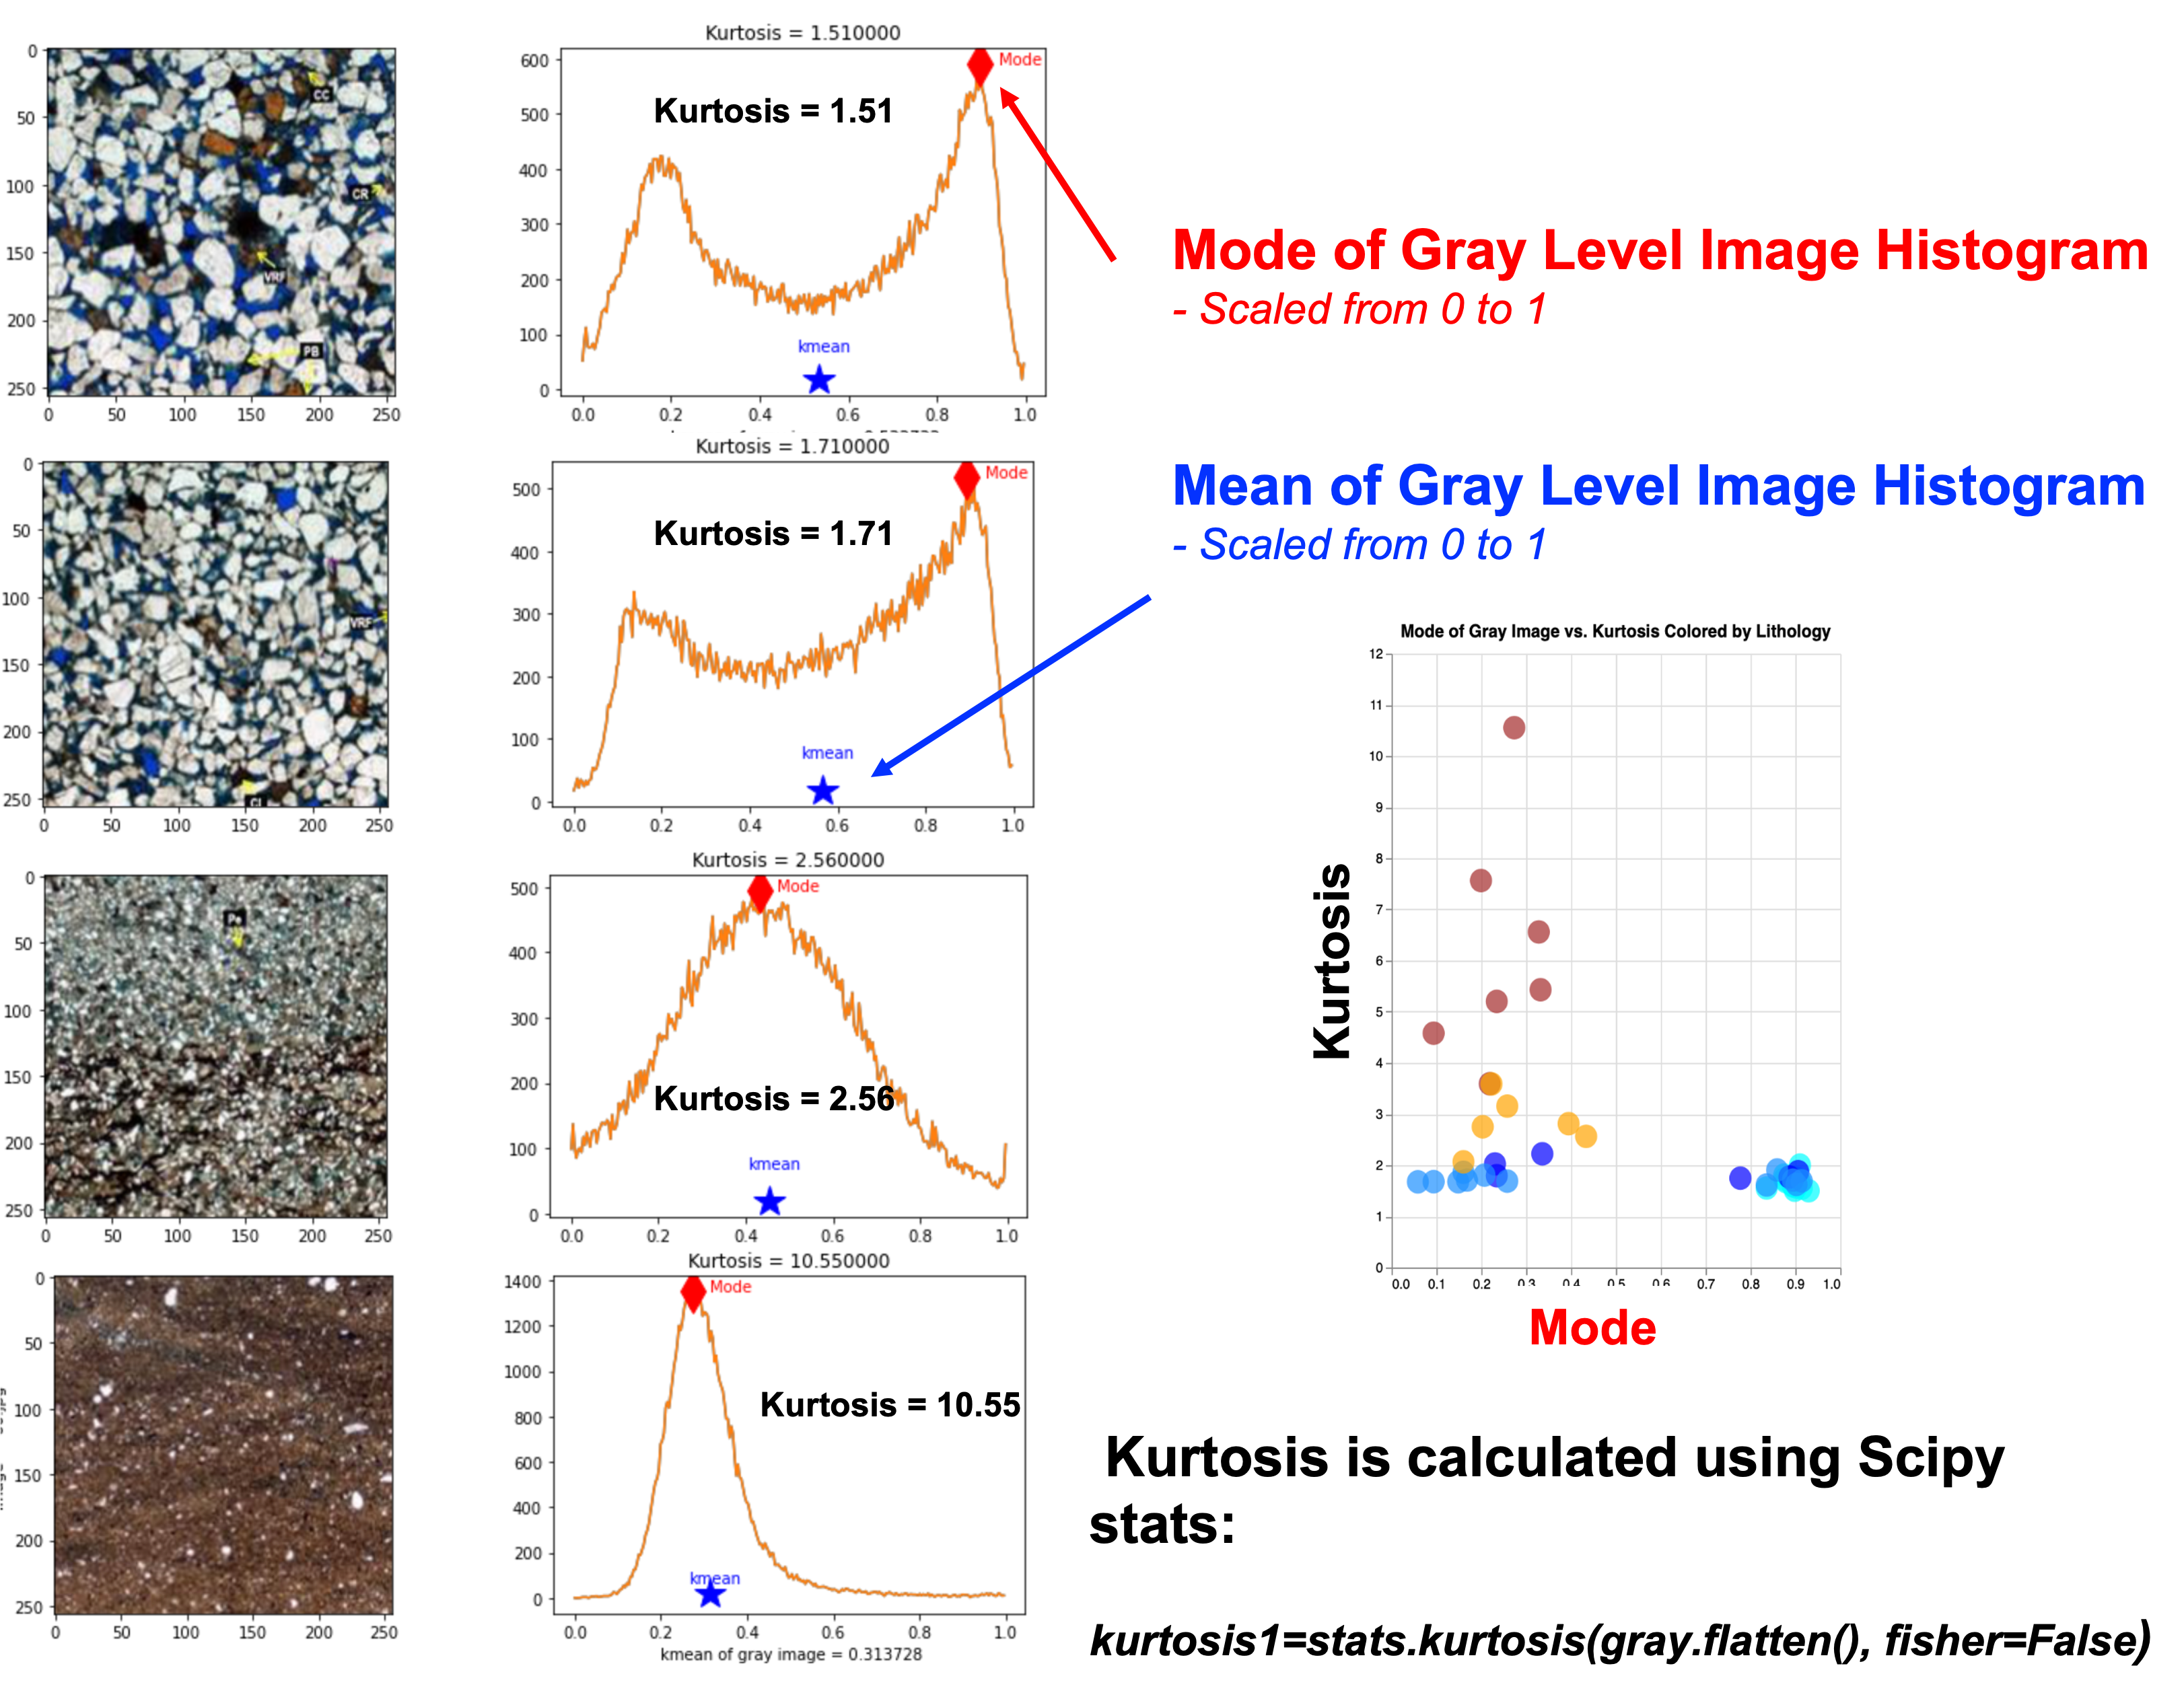

# Gray Image Kurtosis vs. Mode of gray-level histogram showing Thin Sections of selected samples:

In [ ]:
#------------------------------------------------
#
#   Porosity vs. Permeability Cross Plot
#
#------------------------------------------------
# Brush for selection
brush = alt.selection(type='interval')

chart = alt.Chart(source).mark_circle(size=300).encode(
    alt.X('Porosity:Q',
        scale=alt.Scale(domain=(0, 0.35))),
    #y='Perm',
    alt.Y('Permeability:Q',scale=alt.Scale(type='log', base=10,domain=(.01, 1000))),
    
    color=alt.condition( brush,'ROCK_INDEX:O', alt.value('lightgray'),
                        scale=alt.Scale(
                        domain=[ 1,         2,         3  ,     4         ,5,       6],
                       range =['cyan', '#1e90ff',  'blue'  , 'orange','brown' ,'black'  ])),

    
    tooltip=['image','Sample','Porosity','Permeability','Lith'],  # Must be a list for the image to render
    
).properties(
    width=550,
    height=550, 

    title='Porosity vs. Permeability Cross Plot Colored by Lithology',
).add_selection(brush)


    
vega_pane = pn.pane.Vega(chart.add_selection(
    brush
))


imgs = alt.Chart(source).mark_image(width=50, height=50).encode(
    url='image'
).facet(
    alt.Facet('image',title='Select Thin Sections', header=alt.Header(labelFontSize=0)),
    columns=10,
).transform_window(
    row_number='row_number()'
).transform_filter(
    brush
).transform_window(
    rank='rank(row_number)'
).transform_filter(
   alt.datum.rank<21
)





#------------------------------------------------
#
#       Text Data for Routine Core Analysis data
#
#------------------------------------------------
# Base chart for data tables
ranked_text = alt.Chart(source7).mark_text(align='right').encode(
    y=alt.Y('row_number:O',axis=None)
).transform_window(
    row_number='row_number()'
).transform_filter(
    brush
).transform_window(
    rank='rank(row_number)'
).transform_filter(
    alt.datum.rank<30
)


# Data Tables
Porosity = ranked_text.encode(text='Porosity:N').properties(title=alt.TitleParams(text='Porosity', align='right'))
Permeability = ranked_text.encode(text='Permeability:N').properties(title=alt.TitleParams(text='Permeability', align='right'))
Sample = ranked_text.encode(text='Sample:N').properties(title=alt.TitleParams(text='Sample', align='right'))
sqrt = ranked_text.encode(text='sqrt(k/phi):N').properties(title=alt.TitleParams(text ='sqrt(k/phi)', align='right'))
#Image = ranked_text.encode(tooltip ='image').properties(title=alt.TitleParams(text ='image', align='right'))
RI = ranked_text.encode(text='ROCK_INDEX:N').properties(title=alt.TitleParams(text='PRT', align='right'))
lith = ranked_text.encode(text='Lith:N').properties(title=alt.TitleParams(text='Lith', align='right'))
#image2 = ranked_text.encode(text='image:M').properties(title=alt.TitleParams(text='Image', align='right'))
#image2='image'


text = alt.hconcat(Sample, Porosity, Permeability,lith) # Combine data tables

#------------------------------------------------
#
#       Cross Plot
#
#------------------------------------------------
kurt = alt.Chart(source).mark_circle(size=300).encode(
    alt.X('Mode_image:Q',
        scale=alt.Scale(domain=(0, 1))),
    #y='Perm',
    alt.Y('Kurtosis:Q',scale=alt.Scale( domain=(.0, 12))),
    
    color=alt.condition( brush,'ROCK_INDEX:O', alt.value('lightgray'),
                        scale=alt.Scale(
                        domain=[ 1,         2,         3  ,     4         ,5,       6],
                        range =['cyan', '#1e90ff',  'blue'  , 'orange','brown' ,'black'  ])),

    tooltip=['image','Sample','Porosity','Permeability','Lith'],  # Must be a list for the image to render
    
).properties(
    width=500,
    height=500, 

    title='Mode of Gray Image vs. Kurtosis Colored by Lithology',

).add_selection(brush)

#------------------------------------------------
#   Concatenate Cross Plot, Text and Pc curves
#------------------------------------------------
# Build visualization
imgs&kurt|text
#&chart
#imgs